In [0]:
import warnings                                  # do not disturbe mode
warnings.filterwarnings('ignore')

# Load packages
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions

# Importing everything from forecasting quality metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error


In [0]:
df = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/within_covid.csv", parse_dates=['ds'])
df_covid = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/Covid.csv")

In [0]:
df_input = df.copy()

In [0]:
df_input['ds'] = pd.to_datetime(df_input['ds'])

In [0]:
df_activations = df_input[['ds', 'simulated']]
df_activations = df_activations.rename(columns = {'simulated':'activations'})
df_activations_index = df_activations.set_index(['ds'])
df_activations.head()

,ds,activations
0,2018-01-07 00:00:00+00:00,4893.0
1,2018-01-14 00:00:00+00:00,4695.0
2,2018-01-21 00:00:00+00:00,4510.0
3,2018-01-28 00:00:00+00:00,4760.0
4,2018-02-04 00:00:00+00:00,4467.0


# Smooth Data

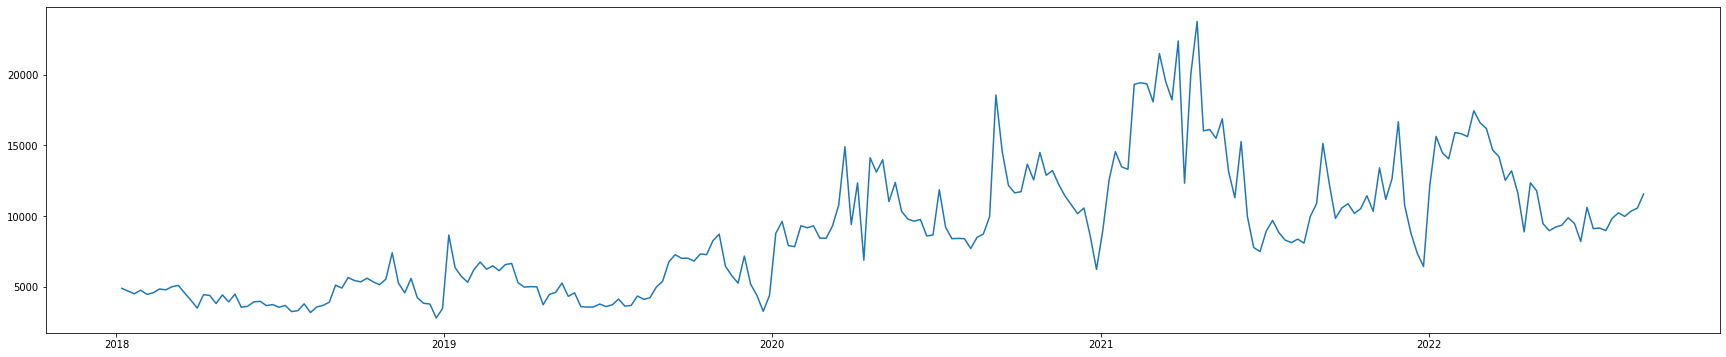

In [0]:
from statsmodels.tsa.ar_model import AutoReg

plt.figure(figsize = (30, 6))
plt.plot(df_activations_index, label = 'activations')
plt.show()

## so we saw the trend of the cost

In [0]:
def test_ts(ts, w, title='test_ts'):
    roll_mean = ts.rolling(window = w).mean()
    roll_std = ts.rolling(window = w).std()
    pd_ewma = ts.ewm(com = 0.5).mean()
    
    plt.figure(figsize = (30, 5))
    plt.clf()
    plt.grid()
    plt.plot(ts, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.plot(pd_ewma, color='yellow', label = 'EWMA')
    plt.legend(loc='best')
    plt.title('Revenue Rolling Mean & Standard Deviation')
    plt.show()

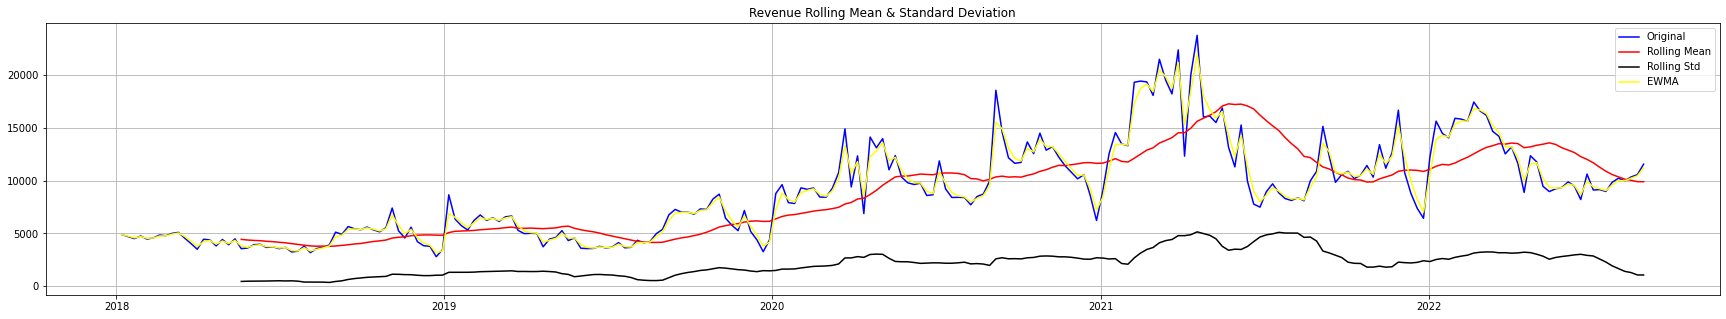

In [0]:
test_ts(df_activations_index, 20, title='test_org')

# Check Order

In [0]:
from statsmodels.tsa.stattools import adfuller

t_stat, p_value, usedlag, nobs, critical_values, resstore  = adfuller(df_activations_index, autolag='AIC')
print(f'ADF Statistic: {t_stat:.2f}')
print(f'p-value: {p_value:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'{key}, {value:.2f}')
      
      
## The data is not stationary

ADF Statistic: -2.38
p-value: 0.15
Critial Values:
1%, -3.46
Critial Values:
5%, -2.87
Critial Values:
10%, -2.57


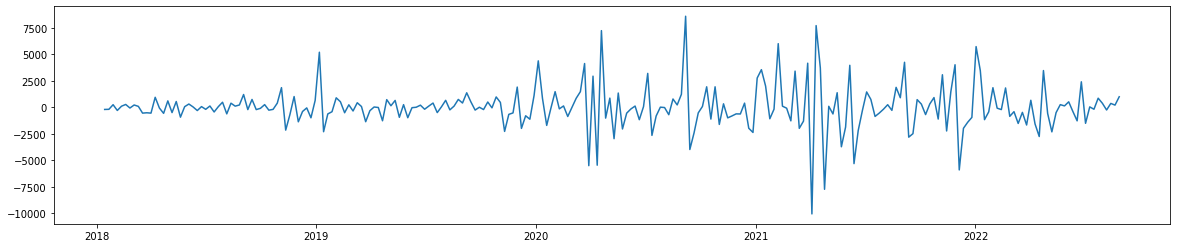

In [0]:
first_diff_cost = df_activations_index.diff()[1:]

plt.figure(figsize = (20, 4))
plt.plot(first_diff_cost, label = 'Diff #1')
plt.show()

In [0]:
from statsmodels.tsa.stattools import adfuller

t_stat, p_value, usedlag, nobs, critical_values, resstore  = adfuller(first_diff_cost, autolag='AIC')
print(f'ADF Statistic: {t_stat:.2f}')
print(f'p-value: {p_value:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'{key}, {value:.2f}')

ADF Statistic: -15.18
p-value: 0.00
Critial Values:
1%, -3.46
Critial Values:
5%, -2.87
Critial Values:
10%, -2.57


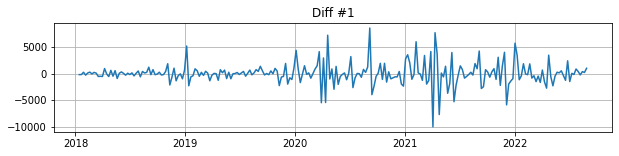

In [0]:
plt.figure(figsize=(10,2))
plt.plot(first_diff_cost)
plt.title('Diff #1')
plt.grid()
plt.show()

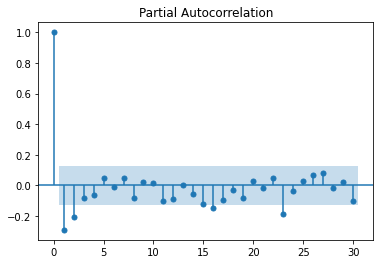

In [0]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(first_diff_cost, lags =30)
plt.show()

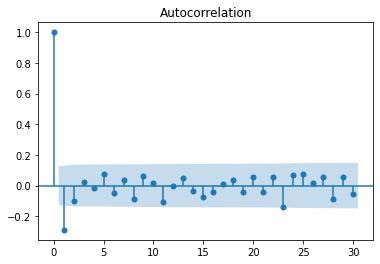

In [0]:
plot_acf(first_diff_cost, lags =30)
plt.show()

# Check Seasonal Order

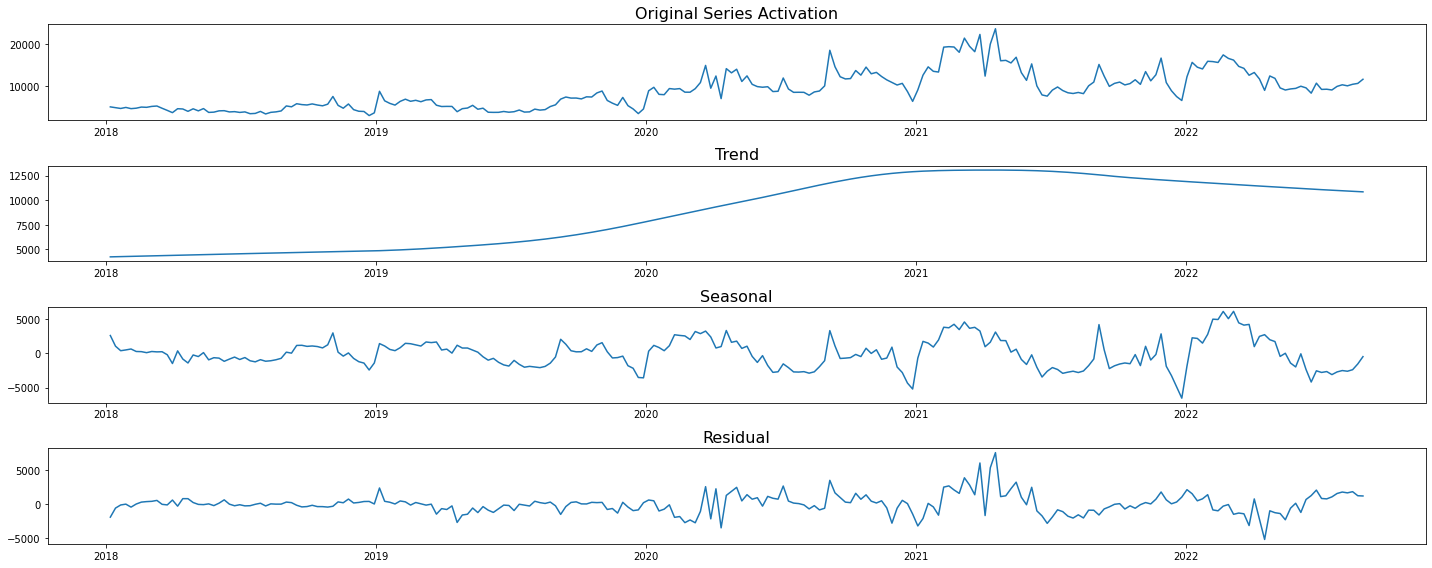

In [0]:
from statsmodels.tsa.seasonal import STL

stl_cost = STL(df_activations_index)
result_activation = stl_cost.fit()

seasonal_act, trend_act, resid_act = result_activation.seasonal, result_activation.trend, result_activation.resid

plt.figure(figsize=(20,8))


plt.subplot(4,1,1)
plt.plot(df_activations_index)
plt.title('Original Series Activation', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend_act)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal_act)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid_act)
plt.title('Residual', fontsize=16)

plt.tight_layout()

In [0]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [0]:
check_stationarity(seasonal_act)

The series is stationary


In [0]:
from statsmodels.tsa.stattools import adfuller

t_stat, p_value, usedlag, nobs, critical_values, resstore  = adfuller(seasonal_act, autolag='AIC')
print(f'ADF Statistic: {t_stat:.2f}')
print(f'p-value: {p_value:.2f}')
for key, value in critical_values.items():
     print('Critial Values:')
     print(f'{key}, {value:.2f}')
      
      
## The data not stationary

ADF Statistic: -4.86
p-value: 0.00
Critial Values:
1%, -3.46
Critial Values:
5%, -2.87
Critial Values:
10%, -2.57


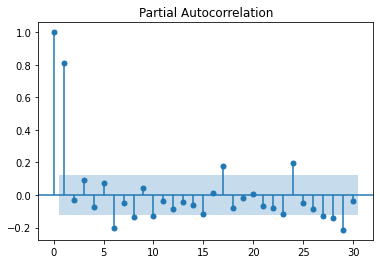

In [0]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(seasonal_act, lags =30)
plt.show()

# P could be:

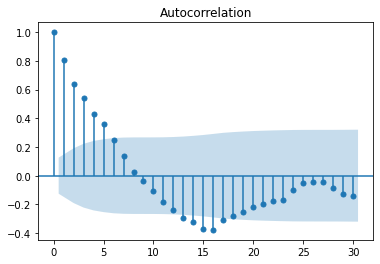

In [0]:
plot_acf(seasonal_act, lags =30)
plt.show()

# Q could be: 

In [0]:
# from pandas.plotting import autocorrelation_plot
# autocorrelation_plot(df_activations_index)

In [0]:
# autocorrelation_plot(seasonal_act)

In [0]:
covid = df_covid[df_covid['countriesAndTerritories'] == 'Germany'].sort_values(by=['year', 'month', 'day'])

In [0]:
covid = covid.iloc[24:]
covid = covid.rename(columns={'dateRep':'ds'})
covid['ds'] = pd.date_range(start='2020-03-01', periods=len(covid), freq='D') ##config the time index to fit in prophet ds
covid['ds'] = pd.to_datetime(covid['ds'])
covid.head(5)

,ds,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2020,continentExp
10165,2020-03-01,1,3,2020,35.0,0.0,Germany,DE,DEU,83166711,Europe
10164,2020-03-02,2,3,2020,43.0,0.0,Germany,DE,DEU,83166711,Europe
10163,2020-03-03,3,3,2020,84.0,0.0,Germany,DE,DEU,83166711,Europe
10162,2020-03-04,4,3,2020,157.0,2.0,Germany,DE,DEU,83166711,Europe
10161,2020-03-05,5,3,2020,186.0,1.0,Germany,DE,DEU,83166711,Europe


In [0]:
covid_index = covid.set_index(['ds']).resample('W').sum().ffill()
covid_index = covid_index.iloc[:-3]
covid_index = covid_index[['cases', 'deaths']].reset_index()
covid_index.tail()

,ds,cases,deaths
126,2022-07-31,495450.0,821.0
127,2022-08-07,362903.0,602.0
128,2022-08-14,298038.0,441.0
129,2022-08-21,263070.0,364.0
130,2022-08-28,227496.0,226.0


In [0]:
df_activations['ds'] = pd.date_range(start = '2018-01-07', end = '2022-08-28', freq = 'W')

df_activations = df_activations.merge(covid_index, how='left', on='ds')
df_activations = df_activations.fillna(0)
df_activations.head()

,ds,activations,cases,deaths
0,2018-01-07,4893.0,0.0,0.0
1,2018-01-14,4695.0,0.0,0.0
2,2018-01-21,4510.0,0.0,0.0
3,2018-01-28,4760.0,0.0,0.0
4,2018-02-04,4467.0,0.0,0.0


In [0]:
df_activations_index = df_activations.set_index(['ds'])
df_activations_index.head()

,activations,cases,deaths
ds,,,
2018-01-07,4893.0,0.0,0.0
2018-01-14,4695.0,0.0,0.0
2018-01-21,4510.0,0.0,0.0
2018-01-28,4760.0,0.0,0.0
2018-02-04,4467.0,0.0,0.0


In [0]:
train = df_activations_index.iloc[:int(len(df_activations_index)*0.9)]
validation = df_activations_index.iloc[int(len(df_activations_index)*0.9):int(len(df_activations_index)*0.95)]
test = df_activations_index.iloc[int(len(df_activations_index)*0.95):]

print("train:" + str(train.shape))
print("validation:" + str(validation.shape))
print("test:" + str(test.shape))

train:(218, 3)
validation:(12, 3)
test:(13, 3)


#MODEL BUILDING

In [0]:
mod = sm.tsa.statespace.SARIMAX(train['activations'],
                                order=(1, 1, 1), 
                                seasonal_order=(1, 0, 15, 12),
                                exog = train['cases']
                                )

results = mod.fit()

print(results.summary().tables[1])

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/databricks/python/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cases          0.0046      0.004      1.069      0.285      -0.004       0.013
ar.L1          0.2302      0.141      1.627      0.104      -0.047       0.507

In [0]:
exog_forecast = validation[['cases']]
exog_forecast_train = train[['cases']]
train_pred = results.predict(start=train.index[0], end=train.index[int(len(train))-1], dynamic=False, exog = exog_forecast_train)
val_pred = results.predict(start=validation.index[0], end=validation.index[int(len(validation))-1], dynamic = False, exog = exog_forecast)

In [0]:
# # line plot of residuals
# residuals = pd.DataFrame(results.resid)
# residuals.plot()
# # density plot of residuals
# residuals.plot(kind='kde')
# # summary stats of residuals
# print(residuals.describe())

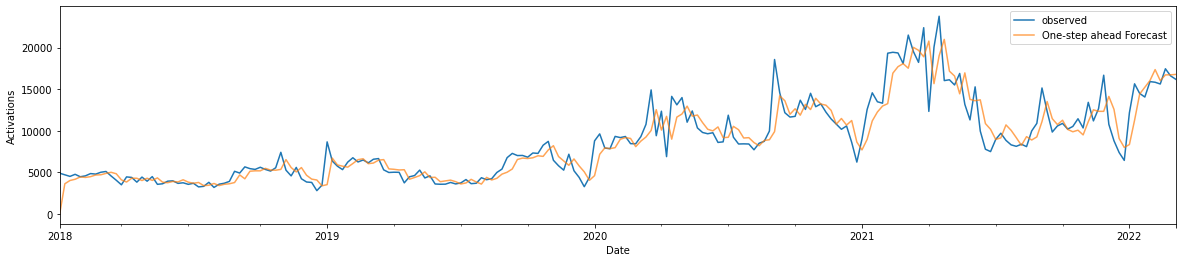

In [0]:
plt.figure(figsize = (20, 4))

ax = train['activations'].plot(label='observed')
train_pred.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Activations')
plt.legend()


plt.show()

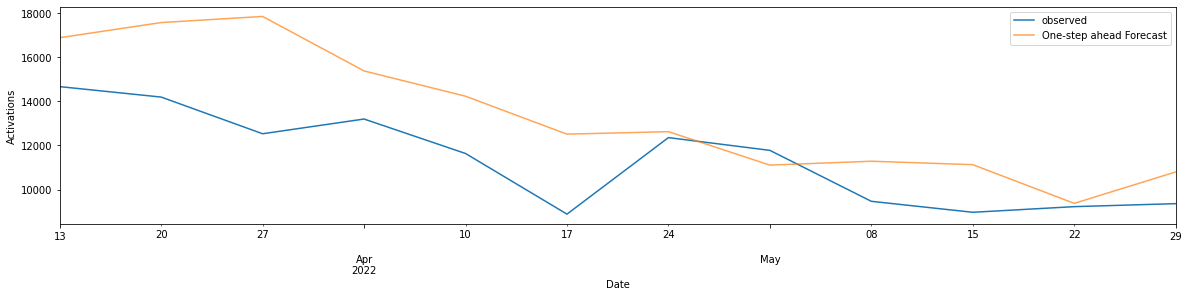

In [0]:
plt.figure(figsize = (20, 4))

ax = validation['activations'].plot(label='observed')
val_pred.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Activations')
plt.legend()


plt.show()

In [0]:
y_forecasted = train_pred
y_truth = train['activations']

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score, mean_squared_error

print("MAPE: " + str(mean_absolute_percentage_error(y_truth, y_forecasted)))
print("r2: " + str(r2_score(y_truth, y_forecasted)))
print("RMSE: " + str(mean_squared_error(y_truth, y_forecasted, squared=False)))

MAPE: 0.1411923537770676
r2: 0.8256168986652745
RMSE: 1910.3944456191548


In [0]:
y_forecasted = val_pred
y_truth = validation['activations']

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score, mean_squared_error

print("MAPE: " + str(mean_absolute_percentage_error(y_truth, y_forecasted)))
print("r2: " + str(r2_score(y_truth, y_forecasted)))
print("RMSE: " + str(mean_squared_error(y_truth, y_forecasted, squared=False)))

MAPE: 0.1911762650411313
r2: -0.6320201876713651
RMSE: 2582.3835153142295


#TEST

In [0]:
train_validation = df_activations_index.iloc[:len(train) + len(validation)]
train_validation_covid = covid.iloc[:len(train) + len(validation)]

print("train_validation:" + str(train_validation.shape))

train_validation:(230, 3)


In [0]:
mod = sm.tsa.statespace.SARIMAX(train_validation['activations'],
                                order=(1, 1, 1), 
                                seasonal_order=(1, 0, 15, 12),
                                exog = train_validation['cases']
                                )

results = mod.fit()

print(results.summary().tables[1])

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/databricks/python/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cases          0.0032      0.003      1.121      0.262      -0.002       0.009
ar.L1          0.2318      0.134      1.724      0.085      -0.032       0.495

In [0]:
exog_forecast = test[['cases']]
test_pred = results.predict(start=test.index[0], end=test.index[int(len(test))-1], dynamic = False, exog = exog_forecast)

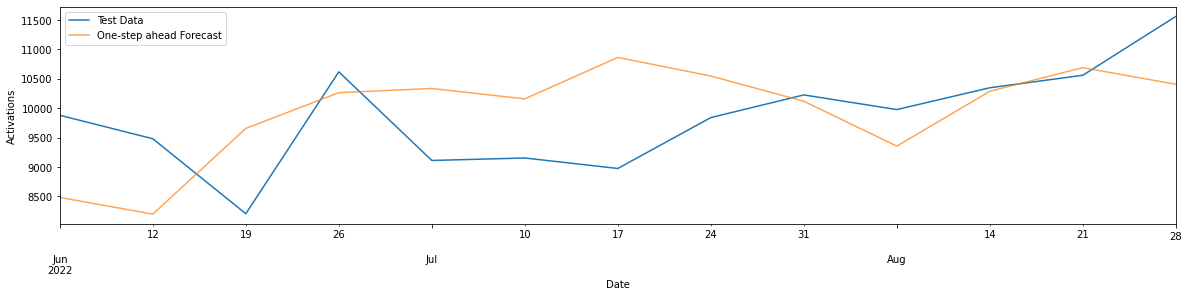

In [0]:
plt.figure(figsize = (20, 4))

ax = test['activations'].plot(label='Test Data')
test_pred.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.set_xlabel('Date')
ax.set_ylabel('Activations')
plt.legend()


plt.show()

In [0]:
prediction = {
  #'ds' : pd.date_range(start = pred_fc.predicted_mean.index[0], periods = len(pred_fc.predicted_mean)),
  'activation_planned_cost' : test_pred
}

prediction = pd.DataFrame(prediction)
prediction.tail(5)

,activation_planned_cost
2022-07-31,10117.941305
2022-08-07,9355.776362
2022-08-14,10288.415900
2022-08-21,10689.569927
2022-08-28,10406.982124


In [0]:
y_forecasted = prediction
y_truth = test['activations']

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score, mean_squared_error

print("MAPE: " + str(mean_absolute_percentage_error(y_truth, y_forecasted)))
print("r2: " + str(r2_score(y_truth, y_forecasted)))
print("RMSE: " + str(mean_squared_error(y_truth, y_forecasted, squared=False)))

MAPE: 0.09255116962351655
r2: -0.5614477861963361
RMSE: 1042.7193422728033


In [0]:
full_pre = train_pred.append([val_pred, test_pred]).to_frame(name='forecasted_activations')
full_pre.index.name = 'ds'
full_pre

,forecasted_activations
ds,
2018-01-07,0.000000
2018-01-14,3622.587937
2018-01-21,4018.634180
2018-01-28,4164.743788
2018-02-04,4444.497666
...,...
2022-07-31,10117.941305
2022-08-07,9355.776362
2022-08-14,10288.415900


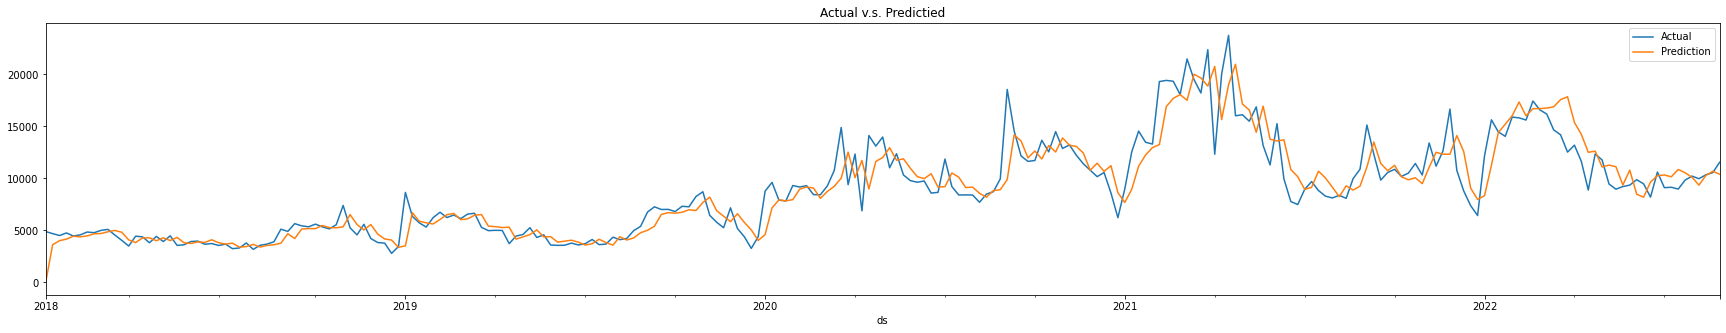

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

df_activations.plot(kind='line',x='ds', y='activations', label='Actual', ax=ax)
full_pre.reset_index().plot(kind='line',x='ds', y='forecasted_activations', label='Prediction', ax=ax)
plt.title('Actual v.s. Predictied')
plt.legend()
plt.show()

# FORECASTING

In [0]:
mod = sm.tsa.statespace.SARIMAX(df_activations_index['activations'],
                                order=(1, 1, 1), 
                                seasonal_order=(1, 0, 15, 12),
                                exog = df_activations_index['cases']
                                )

results = mod.fit()

print(results.summary().tables[1])

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/databricks/python/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cases          0.0026      0.003      1.007      0.314      -0.002       0.008
ar.L1          0.2176      0.129      1.683      0.092      -0.036       0.471

In [0]:
covid_df = pd.date_range(start = '2022-09-01', end = '2022-12-31', freq = 'W').to_frame()
covid_df['cases'] = 0

In [0]:
exog_forecast = covid_df[['cases']]

pred_fc = results.get_forecast(steps = len(covid_df), dynamic=True, exog = exog_forecast)

# confident level
pred_ci = pred_fc.conf_int()

In [0]:
prediction = {
  #'ds' : pd.date_range(start = '2022-06-01', periods = len(pred_fc.predicted_mean)),
  'activation_planned_cost' : pred_fc.predicted_mean
}

prediction_future = pd.DataFrame(prediction)
prediction_future.tail(10)

,activation_planned_cost
2022-10-23,9125.363338
2022-10-30,8859.458203
2022-11-06,9113.322948
2022-11-13,10213.286809
2022-11-20,9984.734219
2022-11-27,10237.435439
2022-12-04,10318.157095
2022-12-11,10023.878092
2022-12-18,9647.587048
2022-12-25,8892.830435


<Figure size 1440x288 with 0 Axes>

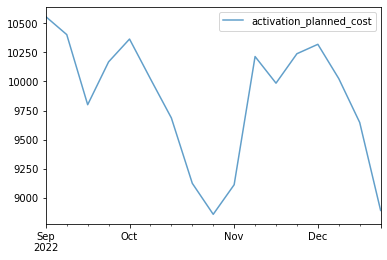

In [0]:
plt.figure(figsize = (20, 4))

prediction_future.plot(label='One-step ahead Forecast', alpha=.7)

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Activations')
plt.legend()


plt.show()

In [0]:
prediction_future = prediction_future.reset_index()
prediction_future.columns = ['ds', 'activations']
prediction_future = prediction_future[['ds', 'activations']]
prediction_future.head(5)

,ds,activations
0,2022-09-04,10555.567650
1,2022-09-11,10401.473288
2,2022-09-18,9799.982293
3,2022-09-25,10167.624311
4,2022-10-02,10363.248127


##Do

In [0]:
future_real = pd.read_csv("/dbfs/FileStore/shared_uploads/chien.liu@hellofresh.com/W_input.csv", parse_dates=['ds'])
future_real = future_real[['ds', 'simulated']]
future_real.head()

,ds,simulated
0,2022-08-07 00:00:00+00:00,9530
1,2022-08-14 00:00:00+00:00,9602
2,2022-08-21 00:00:00+00:00,10011
3,2022-08-28 00:00:00+00:00,10759
4,2022-09-04 00:00:00+00:00,13129


In [0]:
future_real = future_real[future_real['ds'] > '2022-09-01']
# future_real_df = future_real_df[['ds', '']]
future_real_df_index = future_real.set_index(['ds'])
future_real_df_index

,simulated
ds,
2022-09-04 00:00:00+00:00,13129
2022-09-11 00:00:00+00:00,13101
2022-09-18 00:00:00+00:00,11780
2022-09-25 00:00:00+00:00,10800
2022-10-02 00:00:00+00:00,10426
2022-10-09 00:00:00+00:00,11367
2022-10-16 00:00:00+00:00,11168
2022-10-23 00:00:00+00:00,11180
2022-10-30 00:00:00+00:00,11349


In [0]:
forecast_df = prediction_future[prediction_future['ds'] > '2022-09-01']
forecast_df = prediction_future[prediction_future['ds'] < '2022-11-27'].set_index(['ds'])
forecast_df

,activations
ds,
2022-09-04,10555.567650
2022-09-11,10401.473288
2022-09-18,9799.982293
2022-09-25,10167.624311
2022-10-02,10363.248127
2022-10-09,10021.864089
2022-10-16,9686.144358
2022-10-23,9125.363338
2022-10-30,8859.458203


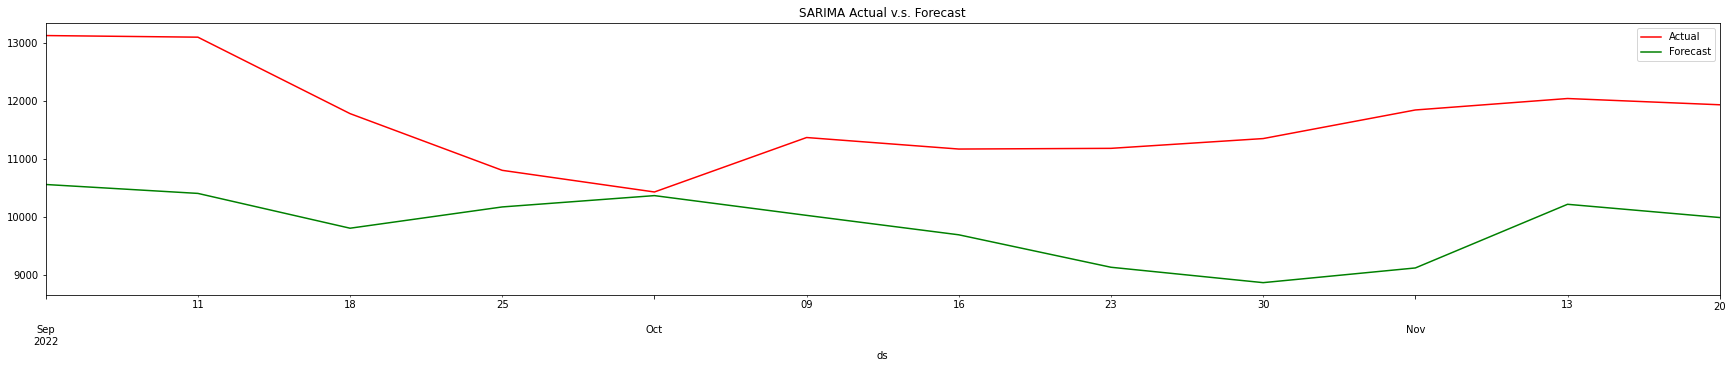

In [0]:
f, ax = plt.subplots(figsize=(30, 5))

future_real_df_index.plot(kind='line',y='simulated', color='red', label='Actual', ax=ax)
forecast_df.plot(kind='line',y='activations', color='green',label='Forecast', ax=ax)
plt.title('SARIMA Actual v.s. Forecast')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import mean_absolute_percentage_error,  r2_score, mean_squared_error

y_true = future_real_df_index
y_pred = forecast_df

print('mape:', mean_absolute_percentage_error(y_true, y_pred))
print('r2:', r2_score(y_true, y_pred))
print('RMSE', mean_squared_error(y_true, y_pred, squared=False))

mape: 0.15286938255242313
r2: -5.370715639194129
RMSE 1984.2369286041849
